# Modelling Brand Choice Probability

In this notebook, we explore how to model brand choice probability. In other words, we want to know which of the available brands will a customer buy, given that the customer already decided to buy a product from a specific product category. The main objective to develop a statistical model which estimate brand probability for each shopping trip based on historical purchase data. The resulting model can help marketers analyse the behaviour of their customers leading to an increase in customer satisfaction and a boost in sales.

## Code

In [1]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.colors import ListedColormap

from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

import plotly.express as px

sns.set(style='whitegrid')

In [2]:
df_purchases = pd.read_csv('data/fmcg-store-purchases-augmented.csv', index_col=0)

segment_labels = pickle.load(open('models/segment-labels.pickle', 'rb'))

segment_colours = ['lightskyblue', 'red', 'gold', 'green']
segment_colour_palette = sns.color_palette(segment_colours)

In [3]:
def train_model(df_data: pd.DataFrame):
    # For now, we assume that only the price features effect the choice of brand,
    # although other features such as promotion may also have an effect.
    features = [f'Price_{i}' for i in range(1, 6)]
    X = df_data[features]
    y = df_data['Brand']
    
    # Fit a model
    lr = LogisticRegression(solver='sag', max_iter=300)
    lr.fit(X, y)
    
    return lr

def generate_test_data(brand: int, df_data: pd.DataFrame, price_range=(0.5, 3.5)):
    price_range_arr = np.arange(price_range[0], price_range[1], 0.01).reshape(-1, 1)
    df_test_data = pd.DataFrame(index=np.arange(price_range_arr.shape[0]))
    
    for i in range(1, 6):
        if i != brand:
            # Fix the price of other brands to their mean
            df_test_data[f'Price_{i}'] = np.mean(df_data[f'Price_{i}'])
        else:
            # Vary the prices of the brand of interest
            df_test_data[f'Price_{i}'] = price_range_arr

    return df_test_data

def predict(model: LogisticRegression, df_test_data: pd.DataFrame, brand: int):
    # Generate probabilities for all the brands given the test data
    y_preds = model.predict_proba(df_test_data)
    
    # The prediction matrix `y_preds` has the shape (n_rows, n_classes).
    # Extract probabilities for the chosen brand.
    brand_proba = y_preds[:][:, brand-1].reshape(-1, 1)
    
    # Find the price coefficient for the chosen brand
    price_brand_coeff = lr.coef_[brand-1, brand-1]
    
    return brand_proba, price_brand_coeff

def create_elasticity_data_frame(price_range_arr, price_elasticity):
    elasticity_data = np.concatenate([price_range_arr, price_elasticity], axis=1)
    return pd.DataFrame(elasticity_data, columns=['Price', 'Elasticity'])

def calc_own_brand_price_elasticity(df: pd.DataFrame, brand: int, 
                                    segment: int = None, price_range=(0.5, 3.5)):
    # We are only interested in rows where customer bought one of more chocolates
    df_data = df[df['Incidence'] == 1]
    
    if segment is not None:
        df_data = df_data[df_data['Segment'] == segment]
    
    model = train_model(df_data)
    df_test_data = generate_test_data(brand, df_data, price_range)
    brand_proba, price_brand_coeff = predict(model, df_test_data, brand)
    
    price_range_arr = np.array(df_test_data[f'Price_{brand}']).reshape(-1, 1)
    
    # Compute the elasticity
    price_elasticity = price_brand_coeff * price_range_arr * (1 - brand_proba)
    
    return create_elasticity_data_frame(price_range_arr, price_elasticity)

def calc_cross_brand_price_elasticity(df: pd.DataFrame, own_brand: int, cross_brand: int, 
                                      segment: int = None, price_range=(0.5, 3.5)):
    df_data = df[df['Incidence'] == 1]
    
    if segment is not None:
        df_data = df_data[df_data['Segment'] == segment]
    
    model = train_model(df_data)
    
    # Generate predictions for own brand
    df_test_data_ob = generate_test_data(own_brand, df_data, price_range)
    proba_ob, beta_ob = predict(model, df_test_data_ob, own_brand)
    
    # Generate predictions for cross brand
    df_test_data_cb = generate_test_data(cross_brand, df_data, price_range)
    proba_cb, beta_cb = predict(model, df_test_data_cb, cross_brand)
    
    price_range_arr = np.array(df_test_data_cb[f'Price_{cross_brand}']).reshape(-1, 1)
    
    # Compute the cross-price elasticity
    price_elasticity = -beta_ob * price_range_arr * proba_cb
    
    return create_elasticity_data_frame(price_range_arr, price_elasticity)

def highlight_elasticity_at_point(df_data: pd.DataFrame, price: float, ax, text_coords=(0.6,-2.2)):
    elasticity =  df_data[df_data['Price'] >= price]['Elasticity'].iloc[0]
    arrow_props = None # dict(arrowstyle= '->', color='black', lw=1, ls='-')
    ax.plot(price, elasticity, marker='o', color='black')
    ax.annotate(f'  ({price:.2f}, {elasticity:.2f})', xy=(price, elasticity),
                # xytext=text_coords, arrowprops=arrow_props, 
                va='center')

def plot_price_elasticities_for_segment(segment: int, own_brand: int, cross_brand: int):
    df_elasticity_ob = calc_own_brand_price_elasticity(df_purchases, brand=own_brand, segment=segment)
    df_elasticity_cb = calc_cross_brand_price_elasticity(df_purchases, own_brand=own_brand, cross_brand=cross_brand, segment=segment)
    
    min_price_ob, max_price_ob = df_purchases[f'Price_{own_brand}'].min(), df_purchases[f'Price_{own_brand}'].max()
    min_price_cb, max_price_cb = df_purchases[f'Price_{cross_brand}'].min(), df_purchases[f'Price_{cross_brand}'].max()

    fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
    arrow_props = dict(arrowstyle= '->', color='black', lw=1, ls='-')
    
    sns.lineplot(x='Price', y='Elasticity', data=df_elasticity_ob, color=segment_colours[segment], ax=axes[0])
    axes[0].axvspan(min_price_ob, max_price_ob, color='grey', alpha=0.4)
    axes[0].set_xlabel(f'Price of Brand {own_brand}')
    
    highlight_elasticity_at_point(df_elasticity_ob, min_price_ob, axes[0], text_coords=(0.6, -1.8))
    highlight_elasticity_at_point(df_elasticity_ob, max_price_ob, axes[0], text_coords=(0.6, -2.2))
    
    axes[0].set_title(f'Price Elasticity of Brand {own_brand} for Segment {segment_labels[segment]}\n'
                      f'(Observed Price Range for Brand {own_brand} is '
                      f'between {min_price_ob:.2f} and {max_price_ob:.2f})');

    sns.lineplot(x='Price', y='Elasticity', data=df_elasticity_cb, color=segment_colours[segment], ax=axes[1])
    axes[1].axvspan(min_price_cb, max_price_cb, color='grey', alpha=0.4)
    axes[1].set_xlabel('Price of Brand 4')
    
    highlight_elasticity_at_point(df_elasticity_cb, min_price_cb, axes[1], text_coords=(0.6, 0.14))
    highlight_elasticity_at_point(df_elasticity_cb, max_price_cb, axes[1], text_coords=(0.6, 0.11))
    
    axes[1].set_title(f'Cross-Price Elasticity of Brand {own_brand} w.r.t. Brand {cross_brand}\n'
                      f'(Observed Price Range for Brand {cross_brand} is '
                      f'between {min_price_cb:.2f} and {max_price_cb:.2f})');


## Multinomial Logistic Regression Model

In [4]:
# We are only interested in rows where customer bought one of more chocolates
df_filtered_data = df_purchases[df_purchases['Incidence'] == 1]

In [5]:
# For now, we assume that only the price features effect the choice of brand,
# although other features such as promotion may also have an effect.
features = [f'Price_{i}' for i in range(1, 6)]

X = df_filtered_data[features]
y = df_filtered_data['Brand']

In [6]:
# Fit a model
lr = LogisticRegression(solver='sag')
lr.fit(X, y)

# The coef_ returns the coefficient of the features in the decision function.
# It is an Numpy array with shape (n_classes, n_features). Let us create
# a DataFrame to be better able to interpret the results.
df_coeffients = pd.DataFrame(
    lr.coef_,
    index=[f'Brand {i}' for i in range(1, 6)], 
    columns=[f'Price {i}' for i in range(1, 6)]
)

In [7]:
df_coeffients.T.round(2)

,Brand 1,Brand 2,Brand 3,Brand 4,Brand 5
Price 1,-3.92,1.27,1.62,0.57,0.44
Price 2,0.66,-1.88,0.56,0.40,0.26
Price 3,2.42,-0.21,0.50,-1.40,-1.31
Price 4,0.70,-0.21,1.04,-1.25,-0.29
Price 5,-0.20,0.59,0.45,0.25,-1.09


As an example, let us consider Brand 1. The coefficient of Brand 1 w.r.t. its price is negative. We already know that the higher price of our own product, the lower the purchase probability. So it makes sense the price to be negative. We also observe that the coefficient is positive for Price 2, 3 and 4. There is a positive relationship between our Brand 1's purchase probability and competitor brands 2-4 increasing their prices. So if these brands increase their prices, the higher is the likelihood that consumers switching to Brand 1.

The band choice probability of any brand compared to the other brands are interrelated. The marketing mix tool of our brand reflects, not only the choice probability of our brand, but the choice probabilities for all other brands as well. These effects are known as own brand and cross brand effects. We can examine these effects when we calculate their respective elasticities.

Suppose we are working for Brand 5 so we are mostly interested in knowing the effects of price changes to Brand 5 (Own Price Elasticity). It would also be interesting to find out what would happen if the competitors change their prices (Cross Price Elasticity).

## Own Price Elasticty for Brand 5

Let us focus on the most expensive brand and create own price elasticity.

In [8]:
df_brand_5_elasticities = calc_own_brand_price_elasticity(df_purchases, brand=5)

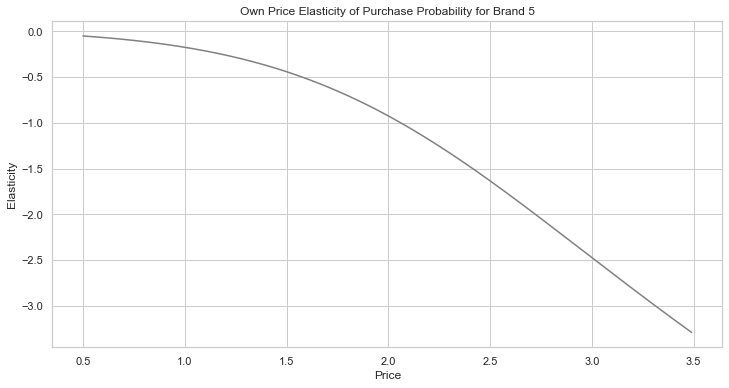

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x='Price', y='Elasticity', data=df_brand_5_elasticities, color='grey', ax=ax)
ax.set_title('Own Price Elasticity of Purchase Probability for Brand 5');

## Cross Price Elasticity for Brand 5 (cross brand 4)

What would happen to the purchase probability of brand 5 if a competitor changed their prices? Since brand 5 is the most expensive brand, price alone may mean very little. We can assume that the product is of high quality. In this regard, the brand which comes closest is Brand 4. So it makes sense to compare Brand 5 with Brand 4.

We want to examine the effect of the changes in price of a competitor brand.
The brand which comes closest to our own brand is brand 4. 
Therefore, we need to examine changes in the price of this brand.
Keep in mind, we could examine the cross price elasticities for any of the remaining brands, 
we just need to update this data frame accordingly to contain the respective brand.

The cross-price elasticity quantifies the change in probability of purchase of a product with a given change in a competitor brand's price:
\begin{align}
E = - \beta_{own} \cdot price_{cross} \cdot Pr(cross)
\end{align}
where
- $\beta_{own}$ is the model's price coefficient of our own brand
- $price_{cross}$ is the price of the alternative brand
- $Pr(cross)$ is the probability of choosing the alternative brand


In [10]:
df_cross_price_elasticities = calc_cross_brand_price_elasticity(df_purchases, own_brand=5, cross_brand=4)

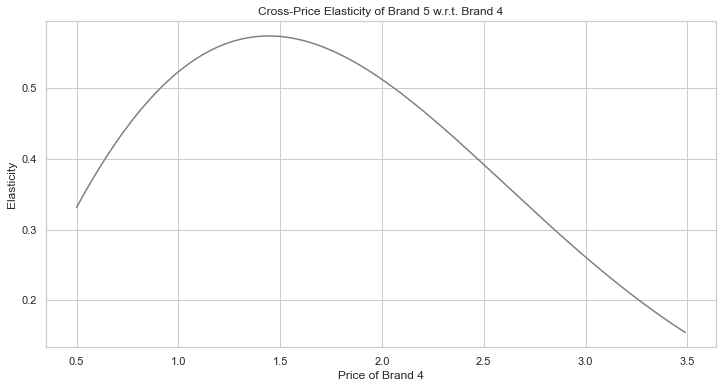

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x='Price', y='Elasticity', data=df_cross_price_elasticities, color='grey', ax=ax)
ax.set_xlabel('Price of Brand 4')
ax.set_title('Cross-Price Elasticity of Brand 5 w.r.t. Brand 4');

Some theory first:
- If $E(crossbrand) > 0$ i.e. the cross-price elasticity is greater than zero then the two products are considered substitutes as both products are from the same product category. However, if we were looking at a different product category, the cross-price elasticity will not necessarily be positive because the two product have nothing in common.
- If $|E(cross)| > |E(own)|$ then the alternative brand is considered a strong substitute.


We observe that the elasticities are positive across the price range as the different brands are substitutes for one another. This indicates that if our competitor, Brand 4, increases prices, the purchase probability of own brand would increase. Although this is not surprising, the elasticity curve shows exactly by how much more. Using the curve, we can gain some insights into the market.


The next question is whether our competitor (Brand 4) is a strong substitute for own brand (Brand 5). It depends on the price point. Let us plot the absolute values of the two elasticities.

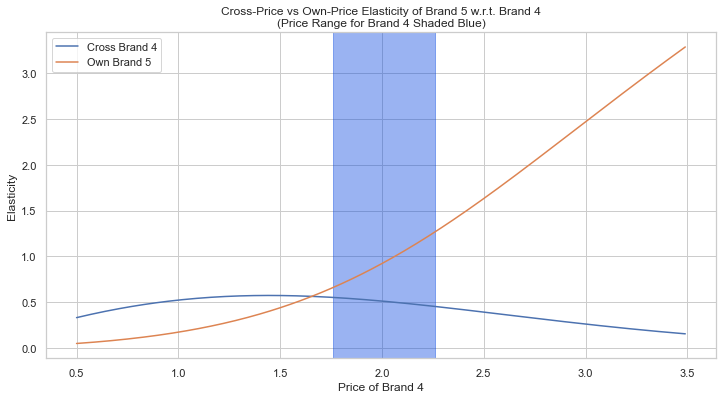

In [12]:
# Take the absolute value of our own price elasticity
df_elasticity_ob = df_brand_5_elasticities.copy()
df_elasticity_ob['Elasticity'] = np.abs(df_brand_5_elasticities['Elasticity'])

fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x='Price', y='Elasticity', data=df_cross_price_elasticities, label='Cross Brand 4', ax=ax)
sns.lineplot(x='Price', y='Elasticity', data=df_elasticity_ob, label='Own Brand 5', ax=ax)
ax.axvspan(df_purchases['Price_4'].min(), df_purchases['Price_4'].max(), color=sns.xkcd_rgb['blue'], alpha=0.4)
ax.set_xlabel('Price of Brand 4')
ax.set_title('Cross-Price vs Own-Price Elasticity of Brand 5 w.r.t. Brand 4\n(Price Range for Brand 4 Shaded Blue)');

In [13]:
df_purchases[['Price_4', 'Price_5']].describe().T

,count,mean,std,min,25%,50%,75%,max
Price_4,58693.0,2.159945,0.089825,1.76,2.12,2.17,2.24,2.26
Price_5,58693.0,2.654798,0.098272,2.11,2.63,2.67,2.70,2.80


We observe that Brand 4 is a strong substitute for Brand 5 for prices up to 1.65. However, we know that these prices are outside of range of prices for Brand 4 which is [1.76, 2.26]. If Brand 4 had a substantially lower price, it would be a very strong competitor of Brand 5. 

In the blue region (where Brand 4's price range is located), we observe that the cross-price elasticity is decreasing. It indicates that with an increase in price, the purchase probability changes more slowly. Since the cross-price elasticity is positive, our purchase probability still increases with the increase in price of Brand 4 but at a slower rate.

Therefore, we can conclude that for the average customer, Brand 4 is a weak substitute for Brand 5. In light of these results, Brand 5 can create a marketing strategy for targeting consumers of Brand 4 and attempt to attract them to buy brand 5. However, targeting the average customer can be a very difficult task because no brand can make anyone happy. Fortunately, we can target consumers in a chosen segment happy.

## Own and Cross-Price Elasticity by Segment

<img src="figures/brand-preference-by-segment-heatmap.png" width="600" />

We should observe the purchase behaviour of the Standard and Well-Off segments because the majority of consumers in these segment are actually purchasing Brand 5 (see the figure above from the descriptive analysis). 

From the descriptive analysis, we found out that the well-off segment has a strong preference for Brand 4. The question is whether we can convince consumers in the well-off segment to choose Brand 5. Let us observe the behaviour of well-off consumers with respect to price changes in Brand 4. 

In [14]:
segment_labels

{0: 'well-off', 1: 'fewer-opportunities', 2: 'career-focused', 3: 'standard'}

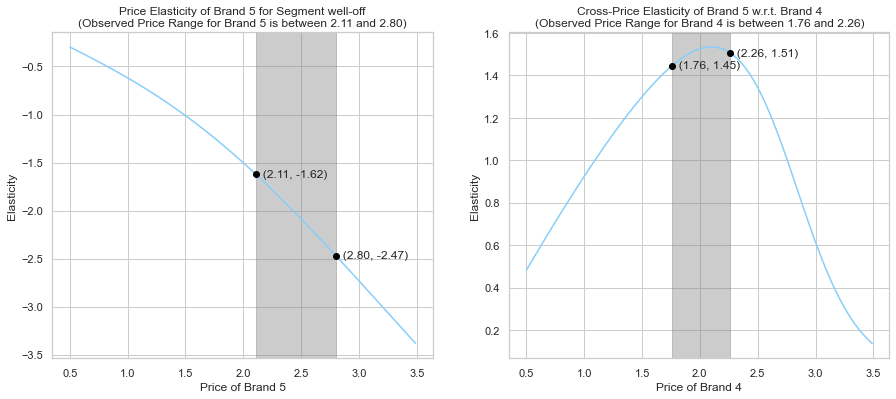

In [15]:
plot_price_elasticities_for_segment(segment=0, own_brand=5, cross_brand=4);

Focusing on the actual price range of Brand 5 (2.11 to 2.88), the own price elasticity indicates that **well-off consumers are elastic to Brand 5**. This observation is to be expected as the well-off segment prefers Brand 4. We saw earlier that approximately 61% of them purchase Brand 4 while only 20% purchase Brand 5. 

The cross price elasticities are positive indicating that for the well-off consumer, Brand 4 is a substitute for Brand 5. 

We can use the graphs above to keep reacting to competitor's changes in their prices.

Suppose:
- Brand 5 costs 2.4. At this price point, the Brand 5's own price elasticity is -1.97.
- Brand 4 costs 2.0. The cross-price elasticity when Brand 4 costs 2.0 is 1.53. 

If our competitor, Brand 4, lowers its price by 1% then the purchase probability would fall by 1.53%. This is not good!

We can strike back by lowering our price by 1%, and thereby increasing the purchase probability by 1.95%.

By reacting to our competitor's price change, the net effect of the two price decreases is a gain in market share.

Knowing the price elasticities, we can react to competitors' price moves and keep the purchase probability constant.

To match our own price decrease, we can match an equation: $2x = 1.5%$ where $x$ is the decrease in price we require to reach 1.5% increase in purchase probability. 
So if Brand 4, decreases their price by 1%, we can decrease ours by $x=0.75\%$ and theoretically we would not lose any customers from the well-off segment.

Next, let us observe the standard segment:

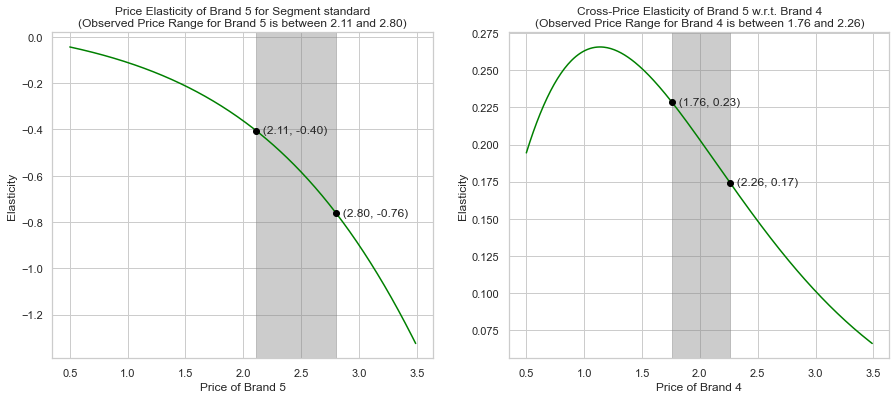

In [16]:
plot_price_elasticities_for_segment(segment=3, own_brand=5, cross_brand=4);

Purchase probability for Brand 5 is inelastic because $|E| < 1$ for the entire observed price range of the brand. This is great news for the marketing team because this means that consumers in this segment are not really affected by price increases of Brand 5. Moreover, the cross-price elasticities have low values which indicates that they are unlikely to switch to competitor brands. Such segments are loyal to the brand. This may sound ruthless but the marketing team can increase prices of Brand 5 without fear of losing too much market share in this segment.

### Elasticity Curves for Fewer-Opportunities and Career-Focused

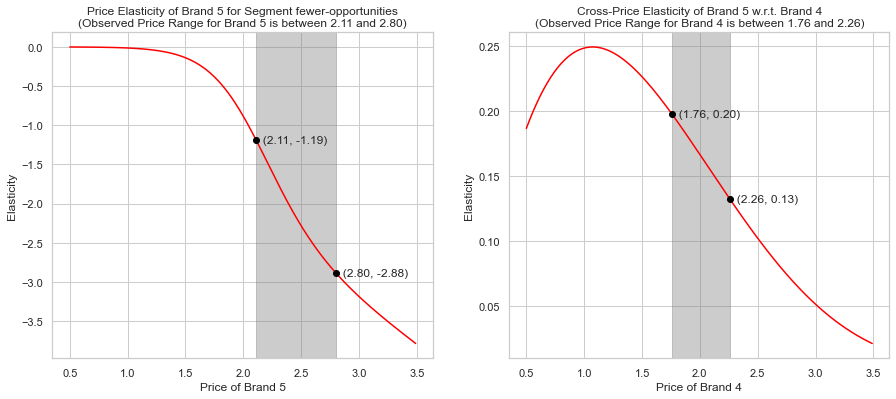

In [17]:
plot_price_elasticities_for_segment(segment=1, own_brand=5, cross_brand=4);

The curve shows that this segment is inelastic to lower price points, then they rapidly become the most elastic customers at higher prices. From the descriptive analysis, we saw that this segment do not like Brand 5 and Brand 4. We do not really have enough observation to obtain an accurate model for this segment. This may be the reason that both curves looks very strange. Therefore, to target this segment, we need to obtain more purchase data from the Fewer-Opportunities segment. In this case, the product may be too pricy for this particular segment so we may not be able to get more data on their behaviour. We can also conclude that this segment is not the target group.

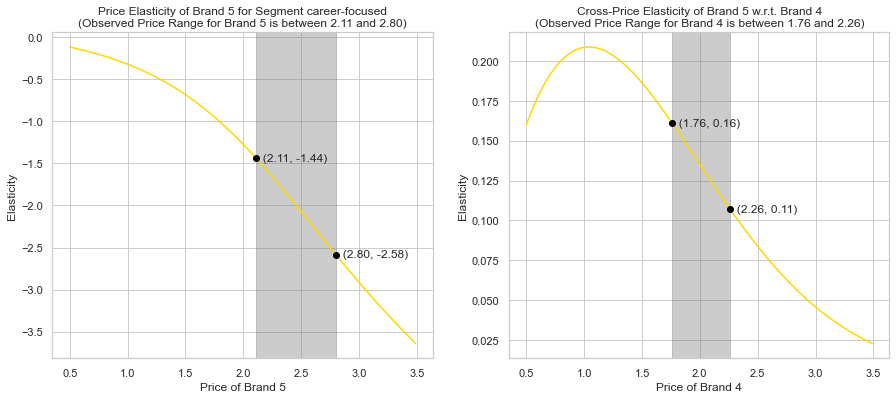

In [18]:
plot_price_elasticities_for_segment(segment=2, own_brand=5, cross_brand=4);

Purchase probability for Brand 5 is elastic because $|E| > 1$ for the entire observed price range of the brand. To win consumers from the Career-Focused segment, our marketing strategy should be to lower prices in this price range in order to increase the purchase probability for this segment. If the segment is not homogeneous, then a marketing strategy based on only this segment may not in our best interest.